# MATH pre-train vs RL evaluation visualization

Use this notebook to collect GSM8K evaluation scores from pre-training and RL runs under `/n/netscratch/dam_lab/Everyone/rl_pretrain/eval_results`, then plot how RL fine-tuning moves performance from its starting checkpoint.



In [29]:
from pathlib import Path
import re
import ast
import pandas as pd
import matplotlib.pyplot as plt

# Root location for evaluation outputs and the metric key to read
BASE_DIR = Path("/n/netscratch/dam_lab/Everyone/rl_pretrain/eval_results")
DATASET_KEY = "test_score/DigitalLearningGmbH/MATH-lighteval"
DATASET_NAME = "MATH"

print(f"Base directory: {BASE_DIR}")

Base directory: /n/netscratch/dam_lab/Everyone/rl_pretrain/eval_results


In [30]:
def read_score(result_path: Path, samples: int, dataset_key: str = DATASET_KEY):
    """Read score from either dict-style logs or majority-vote text.

    Returns:
        dict[int, float]: Dictionary mapping k values to scores.
                         For majority files, returns all Pass@k values found.
                         For dict-style files, returns {samples: score}.
                         Returns {} if no scores found.
    """
    if not result_path.exists():
        return {}

    text = result_path.read_text().splitlines()

    # Majority-format text file (pass@k, single-sample accuracy, etc.)
    if samples > 1 or "majority" in result_path.name:
        scores = {}
        for line in text:
            if "Pass@" in line and ":" in line:
                # Expect formats like: "  Pass@1 : 0.0403 (4.03%)" or "Pass@32 (Any Correct):  0.6884 (68.84%)"
                # Extract k value and score
                import re as _re
                # Match "Pass@<k>" pattern
                k_match = _re.search(r"Pass@(\d+)", line)
                if k_match:
                    k = int(k_match.group(1))
                    # Extract score after the colon
                    parts = line.split(":")
                    if len(parts) > 1:
                        try:
                            score = float(parts[1].split()[0])
                            scores[k] = score
                        except Exception:
                            pass
        if scores:
            return scores
        # If we didn't find Pass@, fall back to the dict parsing below

    # Dict-style log: scan from the bottom for a dict containing the key
    for line in reversed(text):
        try:
            payload = ast.literal_eval(line.strip())
        except Exception:
            continue
        if isinstance(payload, dict) and dataset_key in payload:
            return {samples: payload[dataset_key]}
    return {}

def collect_runs_from_directory(directory: Path, collect_pretrain=True, collect_rl=True, collect_sft=True):
    """Collect pretrain, RL, and SFT runs from a directory."""
    pretrain_rows = []
    rl_rows = []
    sft_rows = []
    
    # Pre-train pattern
    pre_pattern = re.compile(r"1B-step(?P<step>\d+)-(?P<shot>\d+)shot-(?P<samples>\d+)samples-temp(?P<temp>[\d.]+)$")
    
    # RL patterns
    rl_patterns = [
        re.compile(r"1B-step(?P<pt_step>\d+)-rl-step(?P<rl_step>\d+)-0shot-boxed-(?P<samples>\d+)samples-temp(?P<temp>[\d.]+)$"),
        re.compile(r"olmo2_1b_step(?P<pt_step>\d+)_omi_n(?P<num_rollouts>\d+)-step(?P<rl_step>\d+)-rl-0shot-boxed-(?P<samples>\d+)samples-temp(?P<temp>[\d.]+)$"),
    ]
    
    # SFT patterns
    sft_patterns = [
        re.compile(r"OLMo2-1B-step(?P<pt_step>\d+)-stage2-openmathgsm8k-step(?P<sft_step>\d+)-hf-(?P<shot>\d+)shot-boxed-(?P<samples>\d+)samples-temp(?P<temp>[\d.]+)$", re.IGNORECASE),
        re.compile(r"OLMo2-1B-step(?P<pt_step>\d+)-stage2-openmathgsm8k-10epoch-step(?P<sft_step>\d+)-hf-(?P<shot>\d+)shot-boxed-(?P<samples>\d+)samples-temp(?P<temp>[\d.]+)$", re.IGNORECASE),
    ]
    
    if not directory.exists():
        print(f"Warning: Directory {directory} does not exist, skipping...")
        return pretrain_rows, rl_rows, sft_rows
    
    for path in directory.iterdir():
        if not path.is_dir():
            continue
        name = path.name

        # Pre-train collection
        if collect_pretrain:
            pre_match = pre_pattern.match(name)
            if pre_match and not any(tag in name for tag in ["-rl-", "-sft-", "-hf"]):
                samples = int(pre_match.group("samples"))
                result_file = "math_majority_results.txt" if samples > 1 else "math_results.txt"
                scores_dict = read_score(path / result_file, samples=samples)
                
                # Create a row for each k value found
                for k, score in scores_dict.items():
                    pretrain_rows.append(
                        {
                            "step": int(pre_match.group("step")),
                            "shot": int(pre_match.group("shot")),
                            "samples": k,  # Use the actual k value extracted from read_score
                            "temp": float(pre_match.group("temp")),
                            "score": score,
                            "path": str(path),
                        }
                    )
                continue

        # RL collection
        if collect_rl:
            matched = False
            for pat in rl_patterns:
                rl_match = pat.match(name)
                if rl_match:
                    samples = int(rl_match.group("samples"))
                    result_file = "math_majority_results.txt" if samples > 1 else "math_results.txt"
                    scores_dict = read_score(path / result_file, samples=samples)
                    pt_step = int(rl_match.group("pt_step"))
                    rl_step = int(rl_match.group("rl_step"))
                    
                    # Extract num_rollouts if available in the pattern
                    num_rollouts = None
                    if "num_rollouts" in rl_match.groupdict():
                        num_rollouts = int(rl_match.group("num_rollouts")) if rl_match.group("num_rollouts") else None
                    
                    # Create a row for each k value found
                    for k, score in scores_dict.items():
                        rl_rows.append(
                            {
                                "pt_step": pt_step,
                                "rl_step": rl_step,
                                "total_step": pt_step + rl_step,
                                "samples": k,  # Use the actual k value extracted from read_score
                                "temp": float(rl_match.group("temp")),
                                "score": score,
                                "path": str(path),
                                "label": name,
                                "num_rollouts": num_rollouts,
                            }
                        )
                    matched = True
                    break
            if matched:
                continue

        # SFT collection
        if collect_sft:
            for pat in sft_patterns:
                sft_match = pat.match(name)
                if sft_match:
                    samples = int(sft_match.group("samples"))
                    shot = int(sft_match.group("shot")) if "shot" in sft_match.groupdict() else None
                    result_file = "math_majority_results.txt" if samples > 1 else "math_results.txt"
                    scores_dict = read_score(path / result_file, samples=samples)
                    pt_step = int(sft_match.group("pt_step"))
                    sft_step = int(sft_match.group("sft_step"))
                    if "5epoch" in name:
                        epochs = 5
                    else:
                        epochs = 1
                    
                    # Create a row for each k value found
                    for k, score in scores_dict.items():
                        sft_rows.append(
                            {
                                "pt_step": pt_step,
                                "sft_step": sft_step,
                                "total_step": pt_step + sft_step,
                                "shot": shot,
                                "samples": k,  # Use the actual k value extracted from read_score
                                "temp": float(sft_match.group("temp")),
                                "score": score,
                                "path": str(path),
                                "label": name,
                                "sft_epochs": epochs,
                            }
                        )
                    break
    
    return pretrain_rows, rl_rows, sft_rows

# Collect from main directory (pretrain, RL, SFT)
print(f"Collecting from {BASE_DIR}...")
pretrain_rows, rl_rows, sft_rows = collect_runs_from_directory(BASE_DIR, collect_pretrain=True, collect_rl=True, collect_sft=True)

# Create dataframes
pre_df = pd.DataFrame(pretrain_rows)
rl_df = pd.DataFrame(rl_rows)
sft_df = pd.DataFrame(sft_rows)

print(f"Loaded {len(pre_df)} pre-train runs, {len(rl_df)} RL runs, {len(sft_df)} SFT runs.")

# Remove duplicates - keep first occurrence
print(f"Removing duplicates...")
pre_df_before = len(pre_df)
rl_df_before = len(rl_df)
sft_df_before = len(sft_df)

# Only drop duplicates if dataframe is not empty
if not pre_df.empty:
    pre_df = pre_df.drop_duplicates(subset=['step', 'shot', 'samples', 'temp'], keep='first')
if not rl_df.empty:
    rl_df = rl_df.drop_duplicates(subset=['pt_step', 'rl_step', 'samples', 'temp', 'num_rollouts'], keep='first')
if not sft_df.empty:
    sft_df = sft_df.drop_duplicates(subset=['pt_step', 'sft_step', 'samples', 'temp', 'shot', 'sft_epochs'], keep='first')

print(f"Pre-train: {pre_df_before} → {len(pre_df)} ({pre_df_before - len(pre_df)} duplicates removed)")
print(f"RL: {rl_df_before} → {len(rl_df)} ({rl_df_before - len(rl_df)} duplicates removed)")
print(f"SFT: {sft_df_before} → {len(sft_df)} ({sft_df_before - len(sft_df)} duplicates removed)")

Loaded 108 pre-train runs, 193 RL runs, 0 SFT runs.
Removing duplicates...
Pre-train: 108 → 90 (18 duplicates removed)
RL: 193 → 192 (1 duplicates removed)
SFT: 0 → 0 (0 duplicates removed)


In [31]:
if not pre_df.empty:
    display(pre_df.sort_values(["step", "shot", "samples", "temp"]))
else:
    print("Pre-train dataframe is empty")
print()

if not rl_df.empty:
    display(rl_df.sort_values(["pt_step", "rl_step", "samples", "temp"]))
else:
    print("RL dataframe is empty")
print()

if not sft_df.empty:
    display(sft_df.sort_values(["pt_step", "sft_step", "samples", "temp"]))
else:
    print("SFT dataframe is empty")


,step,shot,samples,temp,score,path
0,1000,1,1,0.6,0.0076,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
2,1000,1,8,0.6,0.0230,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
1,1000,1,32,0.6,0.0300,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
3,1000,8,1,0.6,0.0050,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
5,1000,8,2,0.6,0.0066,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
...,...,...,...,...,...,...
54,22000,8,2,0.6,0.0176,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
55,22000,8,4,0.6,0.0332,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
56,22000,8,8,0.6,0.0601,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
57,22000,8,16,0.6,0.1029,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...


,pt_step,rl_step,total_step,samples,temp,score,path,label,num_rollouts
63,1000,100,1100,1,0.6,0.0328,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step1000_omi_n64-step100-rl-0shot-box...,64
65,1000,100,1100,8,0.6,0.0664,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step1000_omi_n64-step100-rl-0shot-box...,64
64,1000,100,1100,32,0.6,0.0862,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step1000_omi_n64-step100-rl-0shot-box...,64
48,1000,200,1200,5,0.6,0.0400,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step1000_omi_n5-step200-rl-0shot-boxe...,5
55,1000,300,1300,1,0.6,0.0318,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step1000_omi_n5-step300-rl-0shot-boxe...,5
...,...,...,...,...,...,...,...,...,...
133,22000,2200,24200,8,0.6,0.1012,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step22000_omi_n5-step2200-rl-0shot-bo...,5
132,22000,2200,24200,32,0.6,0.1174,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step22000_omi_n5-step2200-rl-0shot-bo...,5
134,22000,2700,24700,1,0.6,0.0796,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step22000_omi_n5-step2700-rl-0shot-bo...,5
136,22000,2700,24700,8,0.6,0.1044,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step22000_omi_n5-step2700-rl-0shot-bo...,5



SFT dataframe is empty


In [32]:
# Drop NA rows from RL dataframe
rl_df = rl_df.dropna()

print(f"After dropping NA: {len(rl_df)} RL runs")

After dropping NA: 192 RL runs


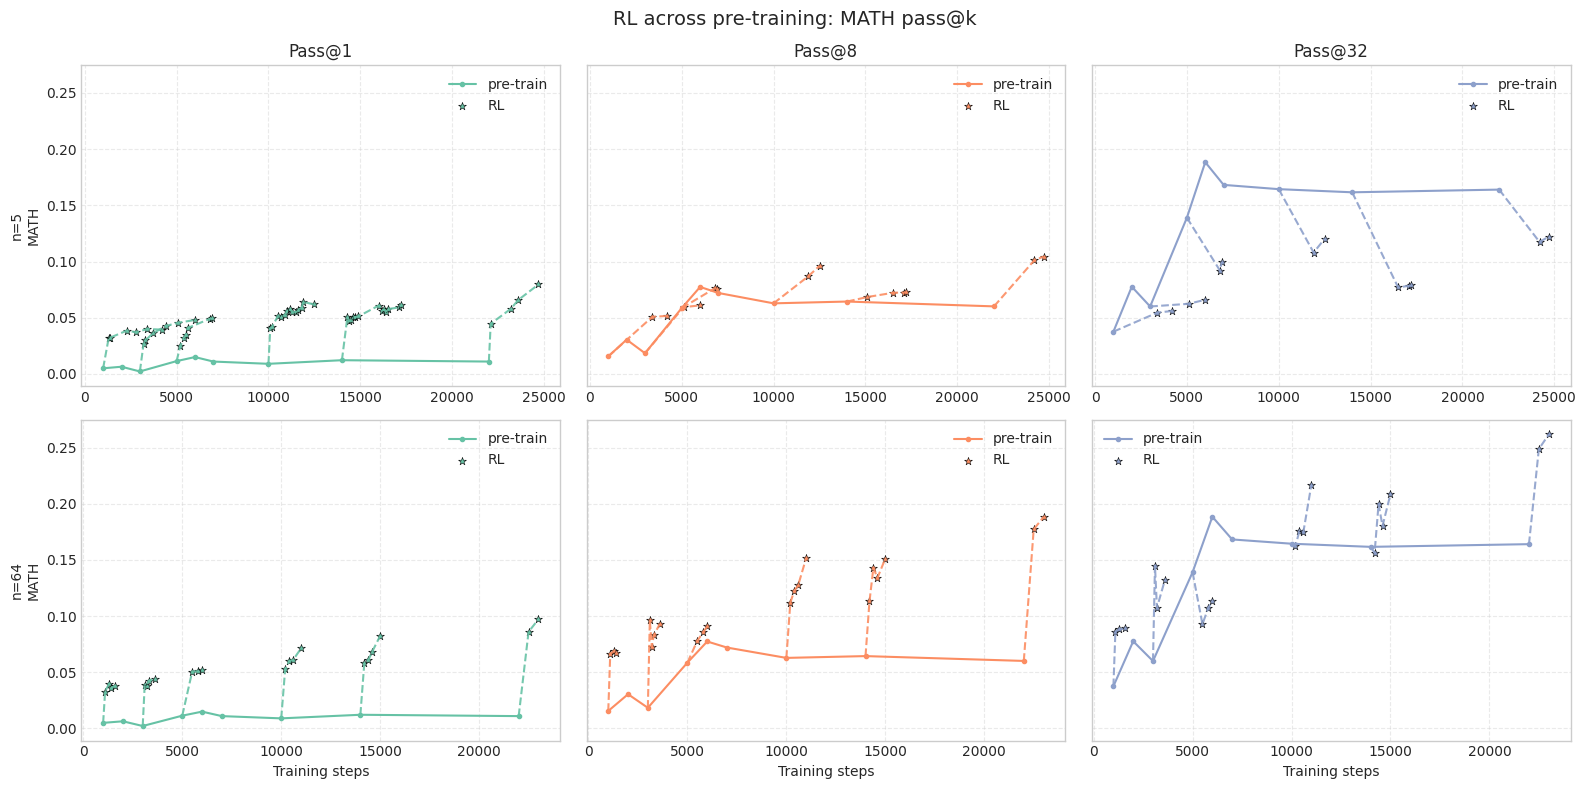

In [33]:
# Refined plotting: per-k subplots, cleaner legend markers, no RL/SFT marker at start
PLOT_SAMPLES = [1, 8, 32]
BASE_PRETRAIN_SHOT = 8
SHOT_BY_SAMPLES = lambda s: BASE_PRETRAIN_SHOT
TEMP_BY_SAMPLES = lambda s: 0.6
FILTER_NUM_ROLLOUTS_LIST = [5, 64]  # Plot both n=5 and n=64

# Get available samples from non-empty dataframes
available_samples_sets = []
if not pre_df.empty:
    available_samples_sets.append(set(pre_df["samples"]))
if not rl_df.empty:
    available_samples_sets.append(set(rl_df["samples"]))
if not sft_df.empty:
    available_samples_sets.append(set(sft_df["samples"]))

available_samples = sorted(set().union(*available_samples_sets)) if available_samples_sets else []
plot_samples = [s for s in PLOT_SAMPLES if s in available_samples]

plt.style.use("seaborn-v0_8-whitegrid")

if not plot_samples:
    fig, ax = plt.subplots(figsize=(20, 14))
    ax.text(0.5, 0.5, "No runs for the selected samples/temp", transform=ax.transAxes, ha="center")
    plt.show()
else:
    n_samples = len(plot_samples)
    n_rollouts = len(FILTER_NUM_ROLLOUTS_LIST)
    
    # Create 2 rows (one for each rollout config) x 3 columns (one for each pass@k)
    fig, axes = plt.subplots(n_rollouts, n_samples, figsize=(16, 4 * n_rollouts), sharey=True)
    if n_rollouts == 1:
        axes = axes.reshape(1, -1)
    if n_samples == 1:
        axes = axes.reshape(-1, 1)
    
    cmap = plt.get_cmap("Set2")

    for rollout_idx, num_rollouts in enumerate(FILTER_NUM_ROLLOUTS_LIST):
        for sample_idx, samples in enumerate(plot_samples):
            ax = axes[rollout_idx, sample_idx]
            target_temp = TEMP_BY_SAMPLES(samples)
            shot = SHOT_BY_SAMPLES(samples)
            color = cmap(sample_idx % cmap.N)

            # Pre-train
            if not pre_df.empty:
                pre_curve = pre_df[(pre_df["samples"] == samples) & (pre_df["shot"] == shot) & (pre_df["temp"] == target_temp)].sort_values("step")
                if not pre_curve.empty:
                    ax.plot(pre_curve["step"], pre_curve["score"], marker=".", color=color, label="pre-train")
            else:
                pre_curve = pd.DataFrame()

            # RL - Filter for num_rollouts
            if not rl_df.empty:
                rl_curve = rl_df[
                    (rl_df["samples"] == samples) & 
                    (rl_df["temp"] == target_temp) & 
                    (rl_df["num_rollouts"] == num_rollouts)
                ].sort_values(["pt_step", "rl_step"])
                rl_labeled = False
                for pt_step, group in rl_curve.groupby("pt_step"):
                    pre_match = pre_curve.loc[pre_curve["step"] == pt_step, "score"] if not pre_curve.empty else pd.Series()
                    start_score = pre_match.iloc[0] if not pre_match.empty else None
                    group_sorted = group.sort_values("rl_step")
                    xs = [pt_step] if start_score is not None else []
                    ys = [start_score] if start_score is not None else []
                    xs.extend((group_sorted["pt_step"] + group_sorted["rl_step"]).tolist())
                    ys.extend(group_sorted["score"].tolist())
                    if not xs:
                        continue
                    ax.plot(xs, ys, linestyle="--", marker=None, color=color, alpha=0.9)
                    if len(xs) > 1:
                        ax.scatter(xs[1:], ys[1:], marker="*", color=color, s=35, edgecolor="k", linewidth=0.4, label="RL" if not rl_labeled else None)
                        rl_labeled = True

            # Title shows pass@k for top row, adds n= for all rows
            if rollout_idx == 0:
                ax.set_title(f"Pass@{samples}")
            
            # Add y-axis label for leftmost column
            if sample_idx == 0:
                ax.set_ylabel(f"n={num_rollouts}\n{DATASET_NAME}")
            
            # Add x-axis label for bottom row
            if rollout_idx == n_rollouts - 1:
                ax.set_xlabel("Training steps")
            
            ax.grid(True, linestyle="--", alpha=0.4)
            ax.legend()

    fig.suptitle(f"RL across pre-training: MATH pass@k", fontsize=14)
    plt.tight_layout()
    plt.show()

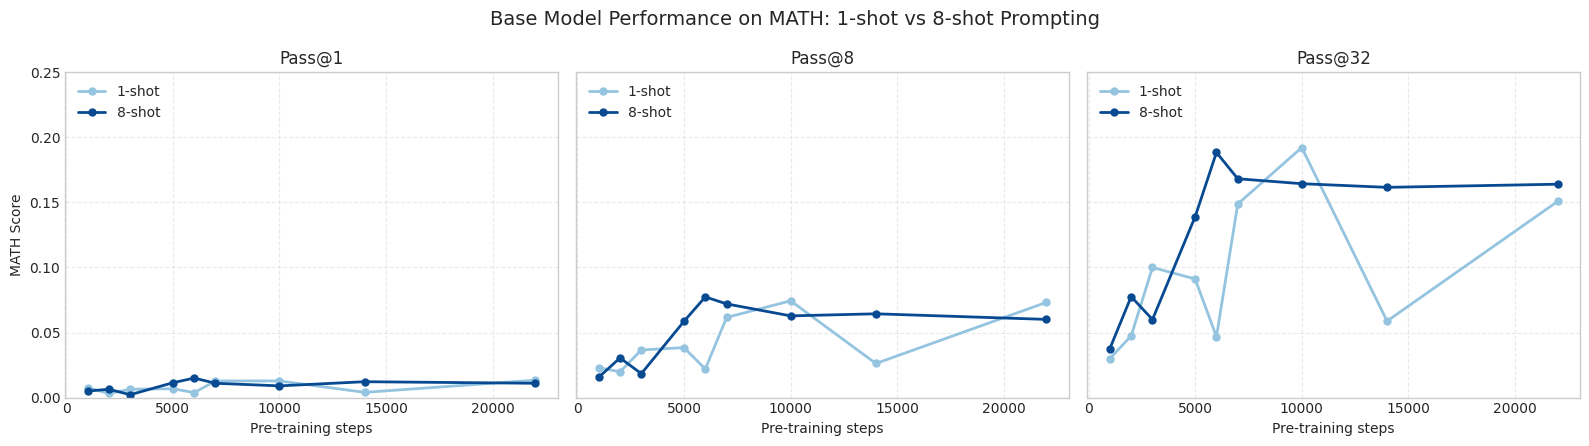

In [34]:
# Plot 1: Base model performance comparison - 0-shot vs 1-shot vs 8-shot for pass@1, pass@8, pass@32
PLOT_SAMPLES_BASE = [1, 8, 32]
SHOT_COMPARISON = [1, 8]  # MATH only has 1-shot and 8-shot data
TARGET_TEMP = 0.6

fig, axes = plt.subplots(1, 3, figsize=(16, 4.5), sharey=True)
cmap = plt.get_cmap("Blues")

for idx, samples in enumerate(PLOT_SAMPLES_BASE):
    ax = axes[idx]

    for shot_idx, shot in enumerate(SHOT_COMPARISON):
        # Color gradient: lighter for 1-shot, darker for 8-shot
        color = cmap(0.4 + 0.5 * shot_idx / (len(SHOT_COMPARISON) - 1))

        # Filter pre-train data for this samples/shot/temp combination
        pre_curve = pre_df[
            (pre_df["samples"] == samples) &
            (pre_df["shot"] == shot) &
            (pre_df["temp"] == TARGET_TEMP)
        ].sort_values("step")

        if not pre_curve.empty:
            ax.plot(
                pre_curve["step"],
                pre_curve["score"],
                marker="o",
                markersize=5,
                color=color,
                label=f"{shot}-shot",
                linewidth=2
            )

    ax.set_title(f"Pass@{samples}", fontsize=12)
    ax.set_xlabel("Pre-training steps")
    if idx == 0:
        ax.set_ylabel(f"{DATASET_NAME} Score")
    ax.set_ylim(0, 0.25)
    ax.grid(True, linestyle="--", alpha=0.4)
    ax.legend(loc="upper left")

fig.suptitle(f"Base Model Performance on {DATASET_NAME}: 1-shot vs 8-shot Prompting", fontsize=14)
plt.tight_layout()
plt.show()

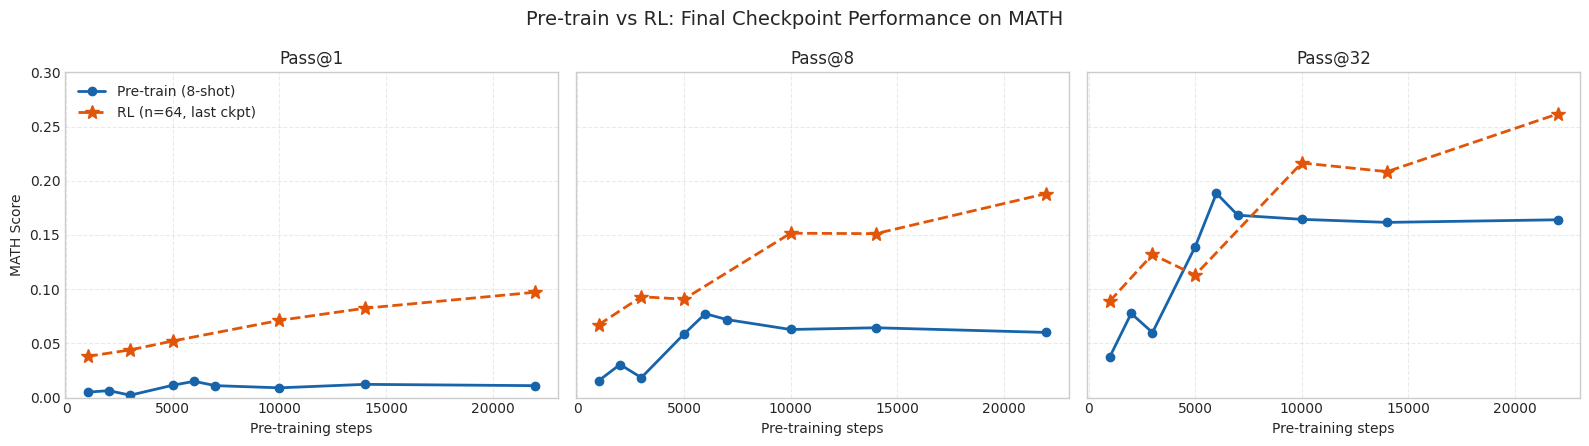

In [35]:
# Plot 3: Base model (8-shot) vs RL (last ckpt) - No SFT for MATH yet
# X-axis is pt_step for all, different markers and colors for each method
PLOT_SAMPLES_BASE = [1, 8, 32]
TARGET_TEMP = 0.6
TARGET_SHOT = 8
RL_ROLLOUTS = 64  # Using n=64 for MATH

fig, axes = plt.subplots(1, 3, figsize=(16, 4.5), sharey=True)

# Different color families for each method
pretrain_color = plt.get_cmap("Blues")(0.8)
rl_color = plt.get_cmap("Oranges")(0.7)

for idx, samples in enumerate(PLOT_SAMPLES_BASE):
    ax = axes[idx]

    # Pre-train (8-shot) - circle markers
    pre_curve = pre_df[
        (pre_df["samples"] == samples) &
        (pre_df["shot"] == TARGET_SHOT) &
        (pre_df["temp"] == TARGET_TEMP)
    ].sort_values("step")

    if not pre_curve.empty:
        ax.plot(
            pre_curve["step"],
            pre_curve["score"],
            marker="o",
            markersize=6,
            color=pretrain_color,
            label="Pre-train (8-shot)",
            linewidth=2
        )

    # RL (last checkpoint per pt_step) - star markers
    rl_subset = rl_df[
        (rl_df["samples"] == samples) &
        (rl_df["temp"] == TARGET_TEMP) &
        (rl_df["num_rollouts"] == RL_ROLLOUTS)
    ]
    # Get the last rl_step for each pt_step
    if not rl_subset.empty:
        rl_last = rl_subset.loc[rl_subset.groupby("pt_step")["rl_step"].idxmax()]
        rl_last = rl_last.sort_values("pt_step")
        ax.plot(
            rl_last["pt_step"],
            rl_last["score"],
            marker="*",
            markersize=10,
            color=rl_color,
            label=f"RL (n={RL_ROLLOUTS}, last ckpt)",
            linewidth=2,
            linestyle="--"
        )

    ax.set_title(f"Pass@{samples}", fontsize=12)
    ax.set_xlabel("Pre-training steps")
    if idx == 0:
        ax.set_ylabel(f"{DATASET_NAME} Score")
    ax.set_ylim(0, 0.3)
    ax.grid(True, linestyle="--", alpha=0.4)
    if idx == 0:
        ax.legend(loc="upper left")

fig.suptitle(f"Pre-train vs RL: Final Checkpoint Performance on {DATASET_NAME}", fontsize=14)
plt.tight_layout()
plt.show()

Found pt_steps: [1000, 3000, 5000, 6000, 7000, 10000, 14000, 22000]


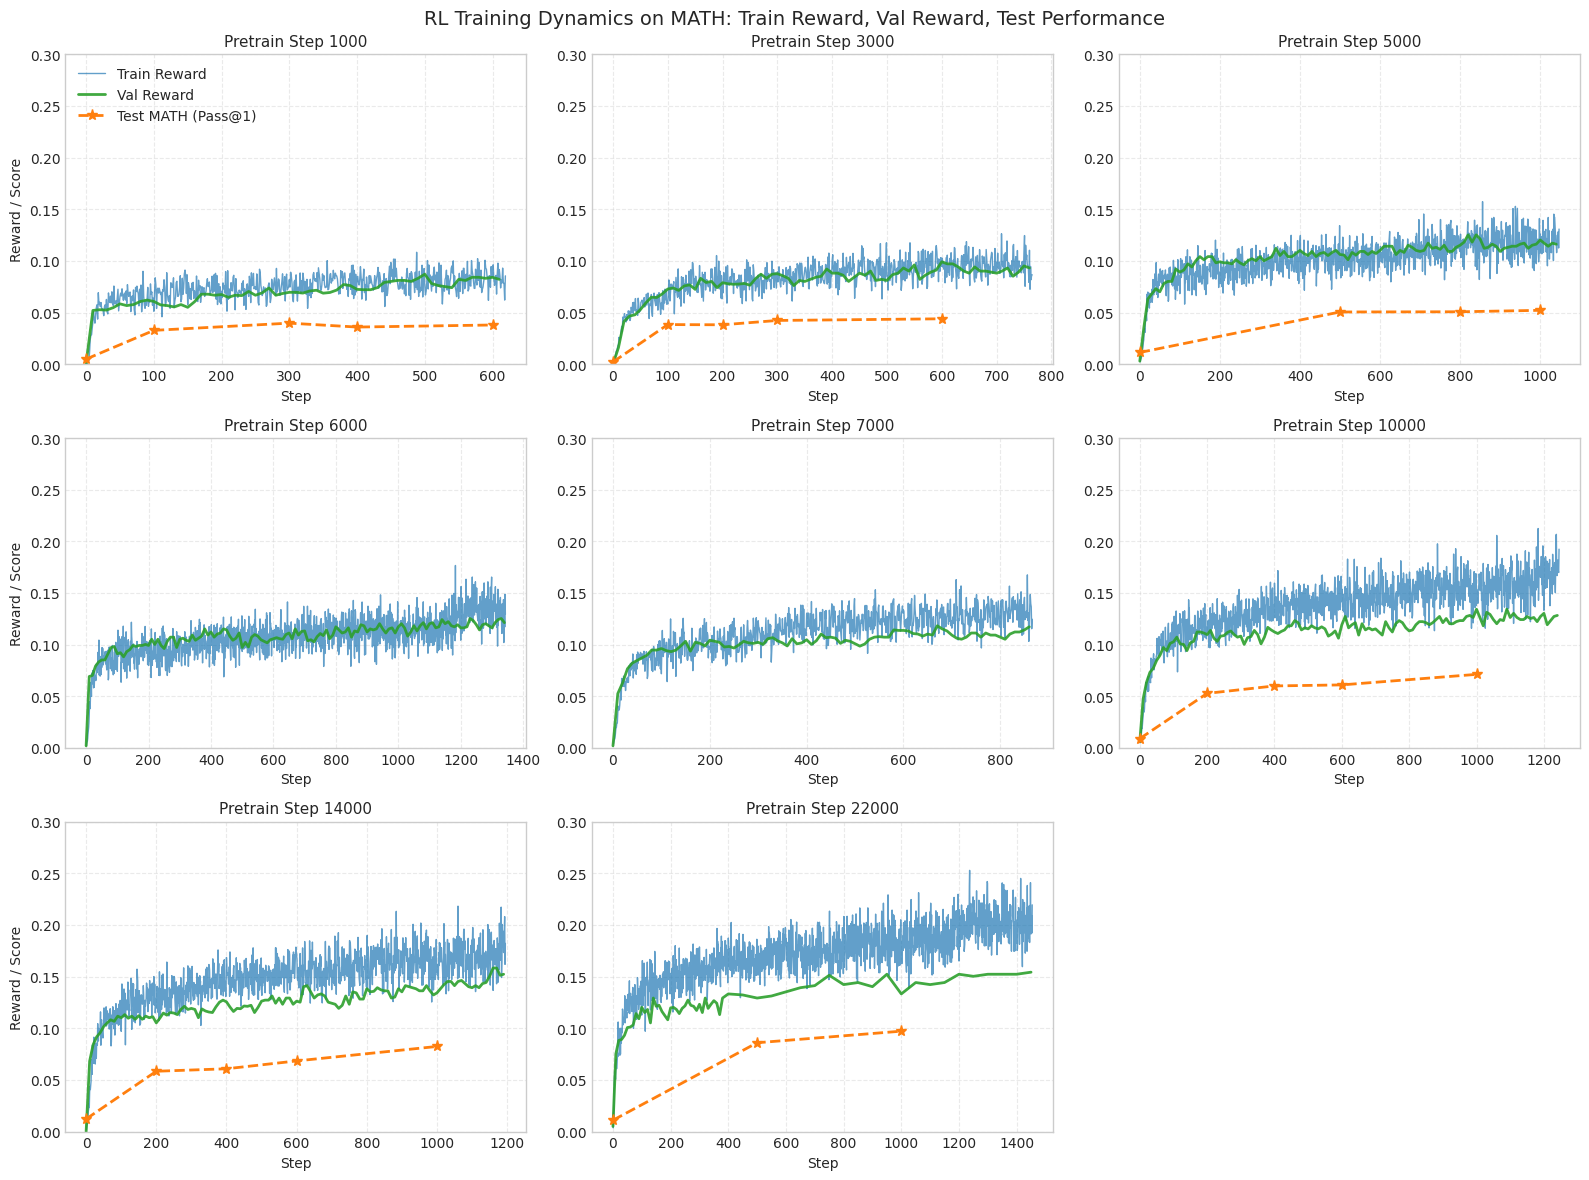

In [41]:
# Plot 4: RL Training Dynamics - 3x3 grid for each pt_step (using combined CSV files)
# Each subplot shows: (1) training reward, (2) validation reward, (3) test MATH performance
import os
import re

RESULT_FILES_DIR = "/n/home05/sqin/rl_pretrain/verl/notebooks/result_files"
TRAIN_CSV = os.path.join(RESULT_FILES_DIR, "stepsall_omi_n64_train_reward.csv")
VAL_CSV = os.path.join(RESULT_FILES_DIR, "stepsall_omi_n64_val_reward.csv")
TARGET_TEMP = 0.6
TARGET_SHOT = 8
RL_ROLLOUTS = 64
TARGET_SAMPLES = 1  # pass@1 for test performance

# Load the combined CSVs
train_all_df = pd.read_csv(TRAIN_CSV)
val_all_df = pd.read_csv(VAL_CSV)

# Extract pt_steps from column headers (format: "Name: olmo2_1b_step{pt_step}_omi_n64 - ...")
def extract_pt_steps_from_columns(df, pattern=r"step(\d+)_omi"):
    pt_steps = set()
    for col in df.columns:
        match = re.search(pattern, col)
        if match:
            pt_steps.add(int(match.group(1)))
    return sorted(pt_steps)

pt_steps_from_files = extract_pt_steps_from_columns(val_all_df)
print(f"Found pt_steps: {pt_steps_from_files}")

# Create 3x3 grid
n_steps = len(pt_steps_from_files)
nrows = 3
ncols = 3
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 12), sharey=False)
axes = axes.flatten()

cmap = plt.get_cmap("viridis")

for idx, pt_step in enumerate(pt_steps_from_files):
    if idx >= nrows * ncols:
        break
    ax = axes[idx]
    
    # Find columns for this pt_step
    train_col = None
    val_col = None
    for col in train_all_df.columns:
        if f"step{pt_step}_omi" in col and "__MIN" not in col and "__MAX" not in col:
            train_col = col
            break
    for col in val_all_df.columns:
        if f"step{pt_step}_omi" in col and "__MIN" not in col and "__MAX" not in col:
            val_col = col
            break
    
    # Plot training reward
    if train_col:
        train_data = train_all_df[["Step", train_col]].dropna()
        if not train_data.empty:
            ax.plot(train_data["Step"], train_data[train_col], color="tab:blue", alpha=0.7, label="Train Reward", linewidth=1)
    
    # Plot validation reward
    if val_col:
        val_data = val_all_df[["Step", val_col]].dropna()
        # Convert to numeric, coercing errors to NaN
        val_data = val_data.copy()
        val_data[val_col] = pd.to_numeric(val_data[val_col], errors='coerce')
        val_data = val_data.dropna()
        if not val_data.empty:
            ax.plot(val_data["Step"], val_data[val_col], color="tab:green", alpha=0.9, label="Val Reward", linewidth=2)
    
    # Plot test MATH performance (pass@1)
    rl_subset = rl_df[
        (rl_df["pt_step"] == pt_step) &
        (rl_df["samples"] == TARGET_SAMPLES) &
        (rl_df["temp"] == TARGET_TEMP) &
        (rl_df["num_rollouts"] == RL_ROLLOUTS)
    ].sort_values("rl_step")
    
    if not rl_subset.empty:
        # Get pre-train score for rl_step=0
        pre_score = pre_df[
            (pre_df["step"] == pt_step) &
            (pre_df["samples"] == TARGET_SAMPLES) &
            (pre_df["shot"] == TARGET_SHOT) &
            (pre_df["temp"] == TARGET_TEMP)
        ]
        
        if not pre_score.empty:
            test_steps = [0] + rl_subset["rl_step"].tolist()
            test_scores = [pre_score.iloc[0]["score"]] + rl_subset["score"].tolist()
        else:
            test_steps = rl_subset["rl_step"].tolist()
            test_scores = rl_subset["score"].tolist()
        
        ax.plot(test_steps, test_scores, color="tab:orange", marker="*", markersize=8, 
                label=f"Test {DATASET_NAME} (Pass@1)", linewidth=2, linestyle="--")
    
    ax.set_title(f"Pretrain Step {pt_step}", fontsize=11)
    ax.set_xlabel("Step")
    if idx % ncols == 0:
        ax.set_ylabel("Reward / Score")
    ax.set_ylim(0, 0.3)
    ax.grid(True, linestyle="--", alpha=0.4)
    if idx == 0:
        ax.legend(loc="upper left", fontsize=10)

# Hide unused subplots
for idx in range(len(pt_steps_from_files), nrows * ncols):
    axes[idx].set_visible(False)

fig.suptitle(f"RL Training Dynamics on {DATASET_NAME}: Train Reward, Val Reward, Test Performance", fontsize=14)
plt.tight_layout()
plt.show()

In [37]:
# fineweb-math for pre-training
# tiny-gsm numbers
# how back we can push the RL
# maybe we can push it way back and make up for pre-training but having to spend lot more FLOPs on RL
# poking around datasets

In [38]:
# Concise table with columns for pass@1/8/32/128 (pre, best SFT, best RL)
TARGET_KS = [1, 8, 32, 128]

rows = []
all_steps = sorted(pre_df["step"].unique().tolist()) if not pre_df.empty else []
for step in all_steps:
    row = {"pt_step": step}
    for k in TARGET_KS:
        temp = TEMP_BY_SAMPLES(k)
        shot = SHOT_BY_SAMPLES(k)

        # Pre-train
        if not pre_df.empty:
            pre_slice = pre_df[(pre_df["step"] == step) & (pre_df["samples"] == k) & (pre_df["temp"] == temp) & (pre_df["shot"] == shot)]
            row[f"pre_p{k}"] = pre_slice.iloc[-1]["score"] if not pre_slice.empty else None
        else:
            row[f"pre_p{k}"] = None

        # SFT
        if not sft_df.empty:
            sft_slice = sft_df[(sft_df["pt_step"] == step) & (sft_df["samples"] == k) & (sft_df["temp"] == temp)]
            if not sft_slice.empty:
                best_sft = sft_slice.loc[sft_slice["total_step"].idxmax()]
                row[f"sft_p{k}"] = best_sft["score"]
            else:
                row[f"sft_p{k}"] = None
        else:
            row[f"sft_p{k}"] = None

        # RL
        if not rl_df.empty:
            rl_slice = rl_df[(rl_df["pt_step"] == step) & (rl_df["samples"] == k) & (rl_df["temp"] == temp)]
            if not rl_slice.empty:
                best_rl = rl_slice.loc[rl_slice["total_step"].idxmax()]
                row[f"rl_p{k}"] = best_rl["score"]
            else:
                row[f"rl_p{k}"] = None
        else:
            row[f"rl_p{k}"] = None

    rows.append(row)

concise_df = pd.DataFrame(rows).sort_values("pt_step").reset_index(drop=True) if rows else pd.DataFrame()
concise_df


,pt_step,pre_p1,sft_p1,rl_p1,pre_p8,sft_p8,rl_p8,pre_p32,sft_p32,rl_p32,pre_p128,sft_p128,rl_p128
0,1000,0.0050,None,0.0394,0.0156,None,0.0516,0.0376,None,0.0560,None,None,NaN
1,2000,0.0064,None,NaN,0.0305,None,NaN,0.0776,None,NaN,None,None,NaN
2,3000,0.0022,None,0.0480,0.0184,None,0.0610,0.0600,None,0.0660,None,None,NaN
3,5000,0.0114,None,0.0498,0.0586,None,0.0758,0.1390,None,0.0994,None,None,0.0988
4,6000,0.0150,None,NaN,0.0774,None,NaN,0.1884,None,NaN,None,None,NaN
5,7000,0.0110,None,NaN,0.0720,None,NaN,0.1682,None,NaN,None,None,NaN
6,10000,0.0090,None,0.0618,0.0628,None,0.0962,0.1644,None,0.1202,None,None,NaN
7,14000,0.0122,None,0.0616,0.0644,None,0.0730,0.1616,None,0.0788,None,None,NaN
8,22000,0.0110,None,0.0796,0.0601,None,0.1044,0.1640,None,0.1222,None,None,NaN
